In [1]:
import os
os.chdir("../")

In [2]:
import os
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
from numpy.random import random, shuffle
%matplotlib inline

In [3]:
def one_hot_encoding(labels, bound):
    result = np.zeros((labels.size, bound))
    result[np.arange(labels.size), labels] = 1
    return result

In [4]:
def relu(vector):
    '''
    ReLU function Max{0, vector} for hidden layer
    '''
    new = np.empty_like(vector)
    np.maximum(vector, 0, new)
    return new

def softmax(X):
    '''
    Softmax function for output layer
    '''
    return np.exp(X) / np.sum(np.exp(X), axis=0)

In [5]:
def loss_and_acc(X, Y, W, B):
    N = X.shape[0]
    Y_hat, _, _ = forward_prop(X, W[0], W[1], W[2], B[0], B[1], B[2])
    loss = -np.sum(Y * np.log(Y_hat)) / N
    acc = (np.argmax(Y_hat, axis=0) ==
           np.argmax(Y, axis=0)).mean() * 100
    return acc,loss

In [6]:
def forward_prop(X, w1, w2, w3, b1, b2, b3):
    z2 = w1.dot(X) + b1
    a2 = relu(z2)
    z3 = w2.dot(a2) + b2
    a3 = relu(z3)
    z4 = w3.dot(a3) + b3
    Y_hat = softmax(z4)

    return Y_hat, [z2,z3,z4], [X,a2,a3]

In [7]:
def d_relu(X):
    # 0-1 
    return np.where(X < 0, 0, 1)

In [8]:
def back_prop(Y_hat, y_ture, w, b, a, z):
    N = Y_hat.shape[1]

    delta3 = - (y_ture - Y_hat)
    delta2 = (w[2].T.dot(delta3))*d_relu(z[1])
    delta1 = (w[1].T.dot(delta2))*d_relu(z[0])
    
    g_w3 = delta3.dot(a[2].T)/ N
    g_w2 = delta2.dot(a[1].T)/ N
    g_w1 = delta1.dot(a[0].T)/ N

    g_b1 = np.mean(delta1, axis=1, keepdims=True)
    g_b2 = np.mean(delta2, axis=1, keepdims=True)
    g_b3 = np.mean(delta3, axis=1, keepdims=True)
    
    return [g_w1,g_w2,g_w3], [g_b1,g_b2,g_b3]

In [9]:
# Definition of functions and parameters
'''
matrix format
input matrx: sample_num*dimension_size
weight matrix: input_dimension*output_dimension
'''
# for example
EPOCH = 100
batch_size = 100
alpha = 0.1

# Read all data from .pkl
(train_images, train_labels, test_images, test_labels) = pickle.load(open('./mnist_data/data.pkl', 'rb'),encoding='latin1')
train_images = np.array(train_images)
train_labels = one_hot_encoding(np.array(train_labels), 10)
test_images = np.array(test_images)
test_labels = one_hot_encoding(np.array(test_labels), 10)

### 1. Data preprocessing: normalize all pixels to [0,1) by dividing 256
train_images = train_images/256
test_images = test_images/256

### 2. Weight initialization: Xavier
n1 = train_images.shape[1]
n2 = 300
n3 = 100
n4 = 10
w1 = (np.random.random((n1,n2))-0.5)*np.sqrt(6/(n1+n2))
w2 = (np.random.random((n2,n3))-0.5)*np.sqrt(6/(n2+n3))
w3 = (np.random.random((n3,n4))-0.5)*np.sqrt(6/(n3+n4))
W = (w1.T, w2.T, w3.T)
b1 = np.zeros((n2,1))
b2 = np.zeros((n3,1))
b3 = np.zeros((n4, 1))
B = (b1,b2,b3)

In [10]:
### 3. training of neural network
loss = np.zeros((EPOCH))
accuracy = np.zeros((EPOCH))
training_size = train_images.shape[0]
all_idx = list(range(training_size))
lambda_ = 0.0005
X_test, Y_test = test_images.T, test_labels.T

for epoch in range(EPOCH):
    print("Epoch %d, Learning Rate=%.2f" % (epoch, alpha))
    if epoch == 50:
        alpha = 0.01
    #shuffle(all_idx)
    for batch_idx in np.array_split(all_idx, int(training_size / batch_size)):
        # Forward propagation
        X_trian, Y_train = train_images[batch_idx].T, train_labels[batch_idx].T

        Y_hat, z, a = forward_prop(X_trian, *W, *B)
        # Back propagation
        #print(np.mean(Y_hat), np.max(Y_hat))
        #break
        g_w, g_b = back_prop(Y_hat,Y_train,W,B,a,z)
        
        # Gradient update
        
        w1 -= alpha * (g_w[0].T + lambda_*w1)
        w2 -= alpha * (g_w[1].T + lambda_*w2)
        w3 -= alpha * (g_w[2].T + lambda_*w3)
        b1 -= alpha * g_b[0]
        b2 -= alpha * g_b[1]
        b3 -= alpha * g_b[2]

    # After an epoch
    # Testing for accuracy
    result = loss_and_acc(X_trian, Y_train, W, B)
    loss[epoch] = result[1]
    print("Train Set: accuracy=%.1f loss=%f" % result)
    result = loss_and_acc(X_test, Y_test, W, B)
    print("Test Set: accuracy=%.1f loss=%f" % result)
    accuracy[epoch] = result[0]

Epoch 0, Learning Rate=0.10
Train Set: accuracy=90.0 loss=0.061889
Test Set: accuracy=77.2 loss=0.931297
Epoch 1, Learning Rate=0.10
Train Set: accuracy=95.0 loss=0.030428
Test Set: accuracy=85.5 loss=0.619770
Epoch 2, Learning Rate=0.10
Train Set: accuracy=95.0 loss=0.023327
Test Set: accuracy=87.4 loss=0.527702
Epoch 3, Learning Rate=0.10
Train Set: accuracy=96.0 loss=0.019869
Test Set: accuracy=88.7 loss=0.472922
Epoch 4, Learning Rate=0.10
Train Set: accuracy=97.0 loss=0.017535
Test Set: accuracy=89.4 loss=0.432931
Epoch 5, Learning Rate=0.10
Train Set: accuracy=97.0 loss=0.015633
Test Set: accuracy=90.3 loss=0.403744
Epoch 6, Learning Rate=0.10
Train Set: accuracy=98.0 loss=0.014049
Test Set: accuracy=91.0 loss=0.379145
Epoch 7, Learning Rate=0.10
Train Set: accuracy=98.0 loss=0.012583
Test Set: accuracy=91.4 loss=0.359601
Epoch 8, Learning Rate=0.10
Train Set: accuracy=99.0 loss=0.011296
Test Set: accuracy=91.7 loss=0.343353
Epoch 9, Learning Rate=0.10
Train Set: accuracy=99.0 lo

Train Set: accuracy=100.0 loss=0.001156
Test Set: accuracy=94.9 loss=0.201375
Epoch 78, Learning Rate=0.01
Train Set: accuracy=100.0 loss=0.001153
Test Set: accuracy=94.9 loss=0.201335
Epoch 79, Learning Rate=0.01
Train Set: accuracy=100.0 loss=0.001150
Test Set: accuracy=94.9 loss=0.201309
Epoch 80, Learning Rate=0.01
Train Set: accuracy=100.0 loss=0.001147
Test Set: accuracy=94.9 loss=0.201247
Epoch 81, Learning Rate=0.01
Train Set: accuracy=100.0 loss=0.001143
Test Set: accuracy=94.9 loss=0.201250
Epoch 82, Learning Rate=0.01
Train Set: accuracy=100.0 loss=0.001140
Test Set: accuracy=94.9 loss=0.201207
Epoch 83, Learning Rate=0.01
Train Set: accuracy=100.0 loss=0.001136
Test Set: accuracy=94.9 loss=0.201174
Epoch 84, Learning Rate=0.01
Train Set: accuracy=100.0 loss=0.001133
Test Set: accuracy=94.9 loss=0.201141
Epoch 85, Learning Rate=0.01
Train Set: accuracy=100.0 loss=0.001130
Test Set: accuracy=94.9 loss=0.201109
Epoch 86, Learning Rate=0.01
Train Set: accuracy=100.0 loss=0.0011

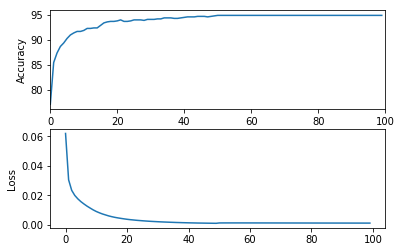

In [11]:
### 4. Plot
# for example
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)

x = range(EPOCH)
plt.sca(ax1)
plt.plot(x, accuracy)
plt.axis([0, 100, min(accuracy)-1, max(accuracy)+1])
plt.ylabel('Accuracy')
plt.sca(ax2)
plt.plot(x, loss)
plt.ylabel('Loss')
plt.show()